In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="jNBAnadLe4NRzxqNNSc0")
project = rf.workspace("jackyzjh").project("soccer-penalty")
version = project.version(2)
dataset = version.download("yolov11")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 83.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Soccer-Penalty-2 in yolov11:: 100%|██████████| 926/926 [00:00<00:00, 6749.54it/s]


In [2]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.165 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.0/235.7 GB disk)


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from ultralytics import YOLO

model = YOLO('commitment/yolo_v11_model/best.pt') #replace with your directory of the model

In [ ]:
for folder in ["1xx", "x1x", "xx1", "0xx", "x0x", "xx0"]:
    results = model.predict(
        source=f"/runs/baseline/laliga penalty kicks edited/{folder}", #replace this with your dataset folder
        imgsz=640,
        conf=0.25,
        save=True,
        save_txt=True,
        save_crop=True,
        project="runs/predict",
        name=f"labels_{folder}"
    )


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/9 (frame 1/28) /content/drive/MyDrive/APS360/laliga penalty kicks edited/1xx/alvarez.mp4: 384x640 1 ball, 4 goalframes, 1 goalie, 1 kicker, 51.5ms
video 1/9 (frame 2/28) /content/drive/MyDrive/APS360/laliga penalty kicks edited/1xx/alvarez.mp4: 384x640 1 ball, 4 goalframes, 1 goalie, 1 kicker, 10.1ms
video 1/9 (frame 3/28) /content/drive/MyDrive/APS360/laliga penalty kicks edited/1xx/alvarez.mp4: 384x640 1 ball, 4 goalframes, 1 goalie, 1 kicker

FileNotFoundError: No images or videos found in /content/drive/MyDrive/APS360/laliga penalty kicks edited/x0x. Supported formats are:
images: {'tif', 'png', 'webp', 'bmp', 'heic', 'pfm', 'mpo', 'jpg', 'jpeg', 'tiff', 'dng'}
videos: {'mkv', 'asf', 'mp4', 'webm', 'mpg', 'gif', 'wmv', 'avi', 'ts', 'm4v', 'mov', 'mpeg'}

In [ ]:
import os
import shutil

# Root folder where your original data images/texts are
SOURCE_ROOT = "/runs/baseline/laliga penalty kicks edited"

# Folder where YOLO saved all predicted .txt files (flat)
PRED_LABELS = "runs/predict"

# The subfolders (classes) you have
SUBFOLDERS = ["1xx", "x1x", "xx1", "0xx", "x0x", "xx0"]

# Extensions of your images (adjust if you use png, jpeg, etc.)
IMAGE_EXTENSIONS = [".jpg", ".jpeg", ".png"]

for txt_file in os.listdir(PRED_LABELS):
    if not txt_file.endswith(".txt"):
        continue

    # Get base filename without extension
    base_name = os.path.splitext(txt_file)[0]

    found_folder = None

    # Search in each subfolder for matching image file
    for folder in SUBFOLDERS:
        folder_path = os.path.join(SOURCE_ROOT, folder)

        for ext in IMAGE_EXTENSIONS:
            image_path = os.path.join(folder_path, base_name + ext)
            if os.path.exists(image_path):
                found_folder = folder
                break
        if found_folder:
            break

    if found_folder is None:
        print(f"WARNING: Could not find matching image for {txt_file}. Skipping.")
        continue

    # Create target subfolder under PRED_LABELS if not exist
    target_dir = os.path.join(PRED_LABELS, found_folder)
    os.makedirs(target_dir, exist_ok=True)

    # Move the txt file
    src_path = os.path.join(PRED_LABELS, txt_file)
    dst_path = os.path.join(target_dir, txt_file)
    shutil.move(src_path, dst_path)

    print(f"Moved {txt_file} to {target_dir}")


In [7]:
import numpy as np
import os

def parse_frame_file(filepath):
    """
    Parse one frame's .txt file into a 16D feature vector.
    """
    class_boxes = {0: [], 1: [], 2: [], 3: []}

    with open(filepath) as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            class_id = int(parts[0])
            features = list(map(float, parts[1:]))
            class_boxes[class_id].append(features)

    frame_features = []

    # Ball (0): use first or zeros
    if class_boxes[0]:
        frame_features.extend(class_boxes[0][0])
    else:
        frame_features.extend([0.0, 0.0, 0.0, 0.0])

    # Goalframe (1): average all detections
    if class_boxes[1]:
        avg_goalframe = np.mean(class_boxes[1], axis=0)
        frame_features.extend(avg_goalframe)
    else:
        frame_features.extend([0.0, 0.0, 0.0, 0.0])

    # Goalie (2): use first or zeros
    if class_boxes[2]:
        frame_features.extend(class_boxes[2][0])
    else:
        frame_features.extend([0.0, 0.0, 0.0, 0.0])

    # Kicker (3): use first or zeros
    if class_boxes[3]:
        frame_features.extend(class_boxes[3][0])
    else:
        frame_features.extend([0.0, 0.0, 0.0, 0.0])

    return frame_features


In [8]:
import os
root_dir = "runs/predict"
for path, dirs, files in os.walk(root_dir):
    print(f"\nPath: {path}")
    print(f"Dirs: {dirs}")
    print(f"Files: {files}")


Path: runs/predict
Dirs: ['labels_0xx', 'labels_xx1', 'labels_x1x', 'labels_1xx']
Files: []

Path: runs/predict/labels_0xx
Dirs: ['crops', 'labels']
Files: ['lewan.avi', 'mbappe.avi']

Path: runs/predict/labels_0xx/crops
Dirs: ['goalframe', 'goalie', 'ball', 'kicker']
Files: []

Path: runs/predict/labels_0xx/crops/goalframe
Dirs: []
Files: ['lewan_262.jpg', 'lewan_7.jpg', 'mbappe_15.jpg', 'lewan_14.jpg', 'lewan_273.jpg', 'lewan_82.jpg', 'lewan_11.jpg', 'lewan_153.jpg', 'mbappe_82.jpg', 'lewan_52.jpg', 'lewan_223.jpg', 'lewan_423.jpg', 'lewan_37.jpg', 'lewan_23.jpg', 'mbappe_44.jpg', 'mbappe_212.jpg', 'lewan_152.jpg', 'mbappe_482.jpg', 'mbappe_223.jpg', 'mbappe_24.jpg', 'mbappe_392.jpg', 'mbappe_41.jpg', 'lewan_282.jpg', 'lewan_252.jpg', 'mbappe_21.jpg', 'mbappe_113.jpg', 'mbappe_193.jpg', 'lewan_31.jpg', 'lewan_322.jpg', 'mbappe_5.jpg', 'mbappe_144.jpg', 'mbappe_462.jpg', 'mbappe_202.jpg', 'mbappe_263.jpg', 'lewan_172.jpg', 'lewan_72.jpg', 'lewan_133.jpg', 'mbappe_23.jpg', 'lewan_30.j

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)  # → (16, 640, 640)
        self.pool = nn.MaxPool2d(2, 2)                                     # → (16, 320, 320)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2) # → (32, 320, 320)
        # → MaxPool → (32, 160, 160)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # → (64, 160, 160)
        # → MaxPool → (64, 80, 80)

        self.fc1 = nn.Linear(64 * 80 * 80, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (16, 320, 320)
        x = self.pool(F.relu(self.conv2(x)))  # (32, 160, 160)
        x = self.pool(F.relu(self.conv3(x)))  # (64, 80, 80)
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset

transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transform

In [11]:
dataset_root = "runs/predict"

full_dataset = datasets.ImageFolder(root=dataset_root, transform=transform)
num_classes = len(full_dataset.classes)

print("Classes:", full_dataset.classes)
print("Total images:", len(full_dataset))

Classes: ['labels_0xx', 'labels_1xx', 'labels_x1x', 'labels_xx1']
Total images: 7871


In [12]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size


In [13]:
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=generator)

In [14]:
# Check length
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

Number of training samples: 4722
Number of validation samples: 1574


In [15]:
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [16]:
root_dir = "runs/predict"
for folder in os.listdir(root_dir):
    path = os.path.join(root_dir, folder)
    if not os.path.isdir(path):
        continue

    if "1xx" in folder:
        label = 0
    elif "x1x" in folder:
        label = 1
    elif "xx1" in folder:
        label = 2
    elif "0xx" in folder:
        label = 3
    elif "x0x" in folder:
        label = 4
    elif "xx0" in folder:
        label = 5
    else:
        print("SKIPPING folder:", folder)
        continue

    print(f"Folder: {folder}  →  Label: {label}")


Folder: labels_0xx  →  Label: 3
Folder: labels_xx1  →  Label: 2
Folder: labels_x1x  →  Label: 1
Folder: labels_1xx  →  Label: 0


Epoch 1, Train Loss: 0.9864
Validation Accuracy: 75.10%
Epoch 2, Train Loss: 0.4758
Validation Accuracy: 91.74%
Epoch 3, Train Loss: 0.2328
Validation Accuracy: 95.11%
Epoch 4, Train Loss: 0.1087
Validation Accuracy: 95.55%
Epoch 5, Train Loss: 0.3009
Validation Accuracy: 93.84%
Epoch 6, Train Loss: 0.0905
Validation Accuracy: 97.08%
Epoch 7, Train Loss: 0.1069
Validation Accuracy: 96.70%
Epoch 8, Train Loss: 0.0828
Validation Accuracy: 95.74%
Epoch 9, Train Loss: 0.0493
Validation Accuracy: 95.68%
Epoch 10, Train Loss: 0.0655
Validation Accuracy: 97.59%


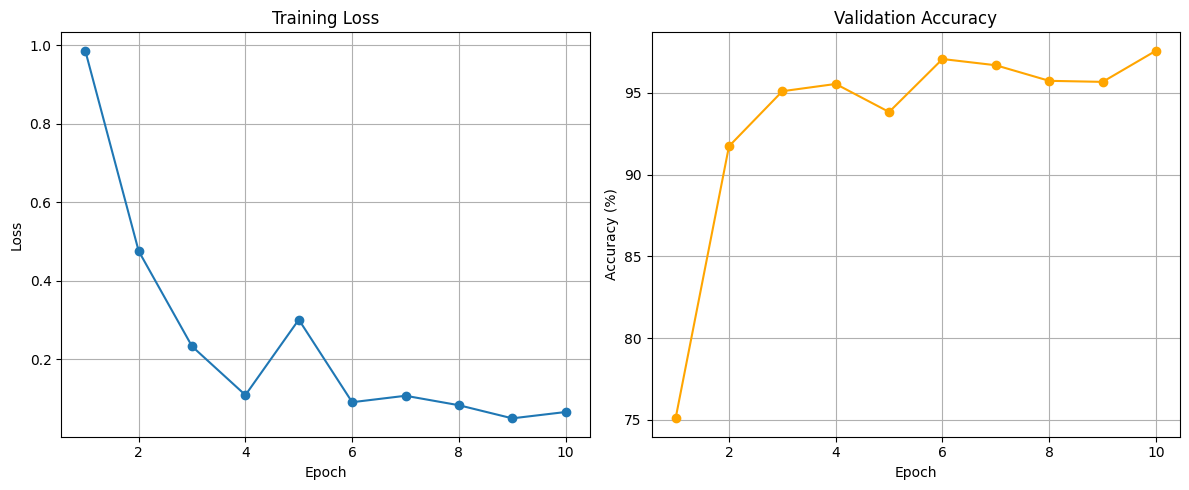

In [17]:
model = SimpleCNN(num_classes=6)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    print(f"Validation Accuracy: {val_acc:.2f}%")

import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, marker='o', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid()

plt.tight_layout()
plt.show()


In [18]:
model.eval()  # set to evaluation mode
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total if total > 0 else 0
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 97.40%


In [19]:
import matplotlib.pyplot as plt
import torchvision
from collections import Counter

# Train class count
train_labels = [label for _, label in train_dataset.samples]
train_counts = Counter(train_labels)
print("Train label counts:", train_counts)

plt.bar(train_counts.keys(), train_counts.values())
plt.title("Train Class Distribution")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.show()

# Validation class count
val_labels = [label for _, label in val_dataset]
val_counts = Counter(val_labels)
print("Validation label counts:", val_counts)

plt.bar(val_counts.keys(), val_counts.values())
plt.title("Validation Class Distribution")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.show()



AttributeError: 'Subset' object has no attribute 'samples'